## Matrix Factorization for Recommender System on Music Data using Stochastic Gradient Descent: Code

Sources of this project: 1). https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/; 2) https://github.com/Apress/hands-on-time-series-analylsis-python; https://github.com/jyu-theartofml/Collaborative_filtering

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#reading the dataset with 50,000 data rows
amazon_music=pd.read_csv("ratings_Digital_Music.csv", header=None, nrows=50000)
amazon_music.columns=["users", "items", "ratings", "timestamp"]
print(amazon_music.shape)
amazon_music.head(10)

(50000, 4)


,users,items,ratings,timestamp
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200
5,A3EBHHCZO6V2A4,5555991584,5.0,1158019200
6,A340XJYJDFSMUG,5555991584,3.0,1190419200
7,A3Q1J7VFGG80EK,5555991584,5.0,975628800
8,A1REP2FMPOXV4A,5555991584,5.0,993427200
9,A3QEKUPBPQ7A2S,5555991584,5.0,1055635200


In [4]:
amazon_music.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   users      50000 non-null  object 
 1   items      50000 non-null  object 
 2   ratings    50000 non-null  float64
 3   timestamp  50000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


Our dataset has 50,000 rows and 4 columns representing information as user id, items, ratings given by the user and timestamp at which time the rating was given.

In [5]:
amazon_music

,users,items,ratings,timestamp
0,A2EFCYXHNK06IS,5555991584,5.0,978480000
1,A1WR23ER5HMAA9,5555991584,5.0,953424000
2,A2IR4Q0GPAFJKW,5555991584,4.0,1393545600
3,A2V0KUVAB9HSYO,5555991584,4.0,966124800
4,A1J0GL9HCA7ELW,5555991584,5.0,1007683200
...,...,...,...,...
49995,A21S26XYPGXJZX,B000002J90,5.0,1031356800
49996,A2LRHMM7XZB6XD,B000002J90,5.0,1135123200
49997,A2WOJ2UU6XYR4V,B000002J90,5.0,907545600
49998,A1DZL5PJ2ECQ8E,B000002J90,5.0,1006214400


In [6]:
#Q1 How many unique users and items in the 50,000 historical ratings?
#reference of script : Lab 2 jupyter notebook

n_users = amazon_music["users"].unique().shape[0]
n_items = amazon_music["items"].unique().shape[0]
n_rating = amazon_music["ratings"].unique().shape[0]

print ('Total number of unique users are %i.' %n_users)
print ('Total number of unique items are %i.' %n_items)
print ('Total number of unique ratings are %i.' %n_rating)

Total number of unique users are 34947.
Total number of unique items are 1449.
Total number of unique ratings are 5.


Out of 50,000 data points we have 34947 number of unique users, 1449 number of unique items and 5 unique ratings.

In [7]:
#generatting user-item matrix
ratings=amazon_music.pivot(index='users', columns='items', values='ratings')

In [8]:
ratings=ratings.fillna(0).values

In [9]:
np.count_nonzero(np.isfinite(ratings))

50638203

In [10]:
np.count_nonzero(np.isnan(ratings))

0

In [11]:
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 5., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 0.10%


In [13]:
# This creats a validation dataset by selecting rows (user) that have 35 or more ratings, then randomly select 15 of those ratings
#for validation set, but set those values to 0 in the training set.

def train_test_split(ratings):
    
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, other wise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:# 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [14]:
train, val = train_test_split(ratings)

(34947, 1449)


In [15]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [17]:
#P is latent user feature matrix
#Q is latent item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

In [19]:
lmbda = 0.4 # Regularization parameter
k = 3 #tweak this parameter
m, n = train.shape  # Number of users and items
n_epochs = 30  # Number of epochs
alpha=0.01  # Learning rate

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [20]:
m,n

(34947, 1449)

In [21]:
prediction(P,Q).shape

(34947, 1449)

In [47]:
train_errors = []
val_errors = []
#Only consider items with ratings 
users,items = train.nonzero() 

for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
        #print(e)
    train_rmse = rmse(prediction(P,Q),train)
    
    val_rmse = rmse(prediction(P,Q),val) 
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

In [48]:
print(train_errors)
print(val_errors)

[1.7120172756362748, 1.5537328415725127, 1.46845262417709, 1.4053824541614903, 1.3529262186049684, 1.3067804618610648, 1.2649268729075118, 1.2262732920867565, 1.190166888706291, 1.1561871340541776, 1.1240465881037678, 1.093538945815725, 1.064509894152453, 1.0368398344918635, 1.0104331593187548, 0.9852113339310595, 0.9611082821011598, 0.9380672183526693, 0.9160384177808063, 0.8949776107062996, 0.8748448042456954, 0.8556034021759922, 0.8372195375153667, 0.8196615596716716, 0.8028996358943307, 0.7869054386656298, 0.7716518987311387, 0.7571130090214866, 0.7432636685955083, 0.7300795584767005]
[1.5218283559556138, 1.2232032398106827, 1.1125988466583576, 1.0581833556422817, 1.0265844620208926, 1.0057879792634523, 0.990718327014192, 0.9789847164698816, 0.969359427593705, 0.9611642706658184, 0.9539994511143743, 0.9476147940019196, 0.9418449474980972, 0.9365751423178827, 0.9317222680210292, 0.9272239496828241, 0.9230319656816034, 0.9191081115360583, 0.9154214957818653, 0.9119467071854763, 0.908

In [22]:
Q.shape

(3, 1449)

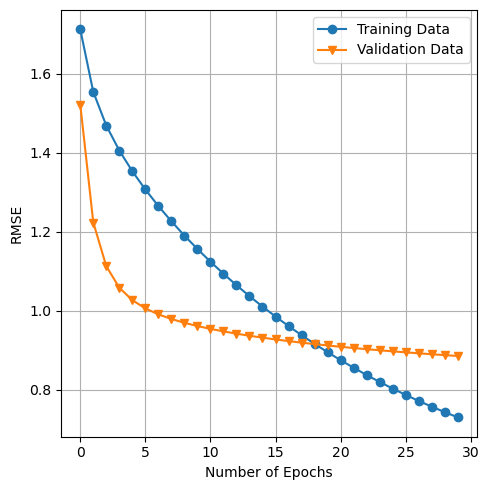

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = [5,5]
plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

In [27]:
SGD_prediction=prediction(P,Q)
SGD_prediction

array([[3.01878903, 3.92301167, 2.91113254, ..., 2.95253568, 3.02172594,
        3.0087235 ],
       [4.66682975, 4.2958874 , 4.21159335, ..., 4.67471143, 4.79660353,
        4.87848479],
       [3.32591868, 3.88601684, 3.12232817, ..., 3.28074287, 3.36440039,
        3.3774021 ],
       ...,
       [4.3125131 , 4.78126309, 4.1940719 , ..., 4.26153258, 4.32114382,
        4.32312668],
       [4.32312425, 4.0673349 , 4.09703914, ..., 4.31677088, 4.37962366,
        4.42168725],
       [5.11984115, 6.19440581, 5.20821109, ..., 5.02049656, 5.04760965,
        4.99721573]])

In [28]:
estimation= SGD_prediction[val.nonzero()]
ground_truth = val[val.nonzero()]
results=pd.DataFrame({'prediction':estimation, 'actual rating':ground_truth})

In [29]:
results

,prediction,actual rating
0,4.620921,5.0
1,4.625627,5.0
2,4.074079,4.0
3,3.825637,4.0
4,4.563950,5.0
...,...,...
490,3.766258,5.0
491,3.305019,4.0
492,3.415337,3.0
493,4.239792,4.0


In [23]:
lmbda = 0.02 # Regularization parameter
k_val = [3, 8, 16, 64] #tweak this parameter
m, n = train.shape  # Number of users and items
n_epochs = 100  # Number of epochs
alpha=0.001  # Learning rate

#Only consider items with ratings 
users,items = train.nonzero() 
value_dict=[]
for kv in k_val:
    
    P = 3 * np.random.rand(kv,m) # Latent user feature matrix
    Q = 3 * np.random.rand(kv,n) # Latent movie feature matrix
    train_errors = []
    val_errors=[]
    
    for epoch in range(n_epochs):
        for u, i in zip(users,items):
            e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
            P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
            Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix

        train_rmse = round(rmse(prediction(P,Q),train),3)
        val_rmse = round(rmse(prediction(P,Q),val),3)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    value={'k': kv, 'train_errors': train_errors, 'val_errors': val_errors}
    print(value)

    value_dict.append(value)

{'k': 3, 'train_errors': [2.874, 2.46, 2.235, 2.091, 1.989, 1.913, 1.853, 1.805, 1.765, 1.731, 1.701, 1.675, 1.652, 1.631, 1.612, 1.595, 1.579, 1.564, 1.55, 1.537, 1.524, 1.513, 1.501, 1.491, 1.481, 1.471, 1.462, 1.452, 1.444, 1.435, 1.427, 1.419, 1.412, 1.404, 1.397, 1.39, 1.383, 1.376, 1.369, 1.363, 1.357, 1.35, 1.344, 1.338, 1.332, 1.327, 1.321, 1.315, 1.31, 1.304, 1.299, 1.294, 1.288, 1.283, 1.278, 1.273, 1.268, 1.263, 1.258, 1.254, 1.249, 1.244, 1.239, 1.235, 1.23, 1.226, 1.221, 1.217, 1.213, 1.208, 1.204, 1.2, 1.195, 1.191, 1.187, 1.183, 1.179, 1.175, 1.171, 1.167, 1.163, 1.159, 1.155, 1.151, 1.147, 1.143, 1.14, 1.136, 1.132, 1.129, 1.125, 1.121, 1.118, 1.114, 1.11, 1.107, 1.103, 1.1, 1.096, 1.093], 'val_errors': [2.615, 2.129, 1.868, 1.699, 1.577, 1.484, 1.409, 1.348, 1.296, 1.251, 1.213, 1.179, 1.15, 1.123, 1.1, 1.078, 1.059, 1.042, 1.026, 1.012, 0.999, 0.987, 0.975, 0.965, 0.955, 0.946, 0.938, 0.93, 0.923, 0.916, 0.909, 0.903, 0.898, 0.892, 0.887, 0.882, 0.877, 0.873, 0.869, 0

In [ ]:
#df_new = df[np.isfinite(df).all(1)]

In [24]:
values_df=pd.DataFrame(value_dict)
values_df

,k,train_errors,val_errors
0,3,"[2.874, 2.46, 2.235, 2.091, 1.989, 1.913, 1.85...","[2.615, 2.129, 1.868, 1.699, 1.577, 1.484, 1.4..."
1,8,"[6.126, 4.394, 3.55, 3.044, 2.704, 2.46, 2.276...","[5.243, 3.615, 2.971, 2.639, 2.438, 2.301, 2.1..."
2,16,"[9.208, 6.034, 4.628, 3.822, 3.297, 2.927, 2.6...","[7.998, 5.237, 4.208, 3.684, 3.367, 3.152, 2.9..."
3,64,"[13.136, 8.008, 6.06, 5.005, 4.321, 3.828, 3.4...","[12.005, 8.475, 7.363, 6.856, 6.571, 6.388, 6...."


In [25]:
values_df=values_df.explode(['train_errors', 'val_errors']).reset_index(drop=True)
values_df

,k,train_errors,val_errors
0,3,2.874,2.615
1,3,2.46,2.129
2,3,2.235,1.868
3,3,2.091,1.699
4,3,1.989,1.577
...,...,...,...
395,64,0.575,5.166
396,64,0.572,5.161
397,64,0.57,5.157
398,64,0.568,5.152


In [26]:
values_df.to_csv('values_k64_alpha0.01_df.csv')

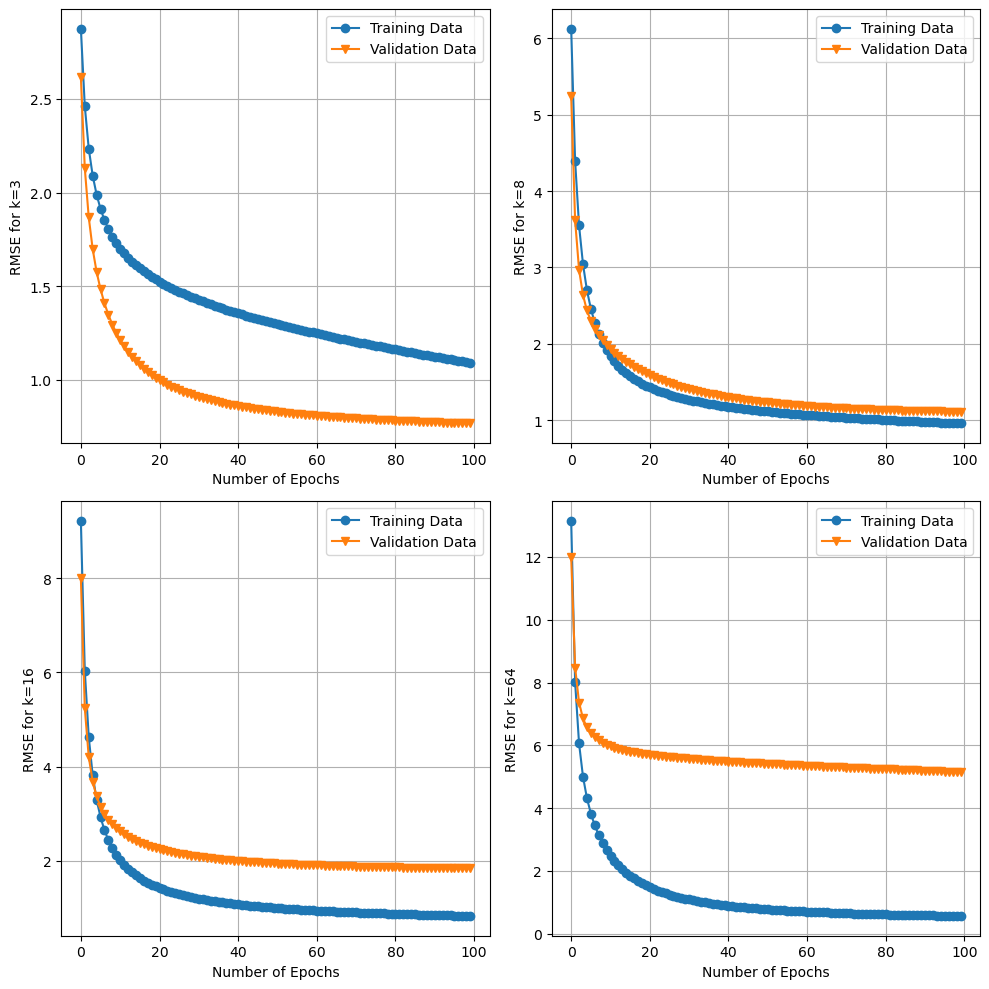

In [27]:
kvalues = values_df.k.unique()
newdf = {elem : pd.DataFrame() for elem in kvalues}

for key in newdf.keys():
    newdf[key] = values_df[:][values_df.k == key]

plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams["figure.autolayout"] = True

plt.subplot(221)
plt.plot(range(n_epochs), 'train_errors', data=newdf[3], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[3], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=3');
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(range(n_epochs), 'train_errors', data=newdf[8], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[8], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=8');
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(range(n_epochs), 'train_errors', data=newdf[16], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[16], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=16');
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(range(n_epochs), 'train_errors', data=newdf[64], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[64], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=64');
plt.legend()
plt.grid()

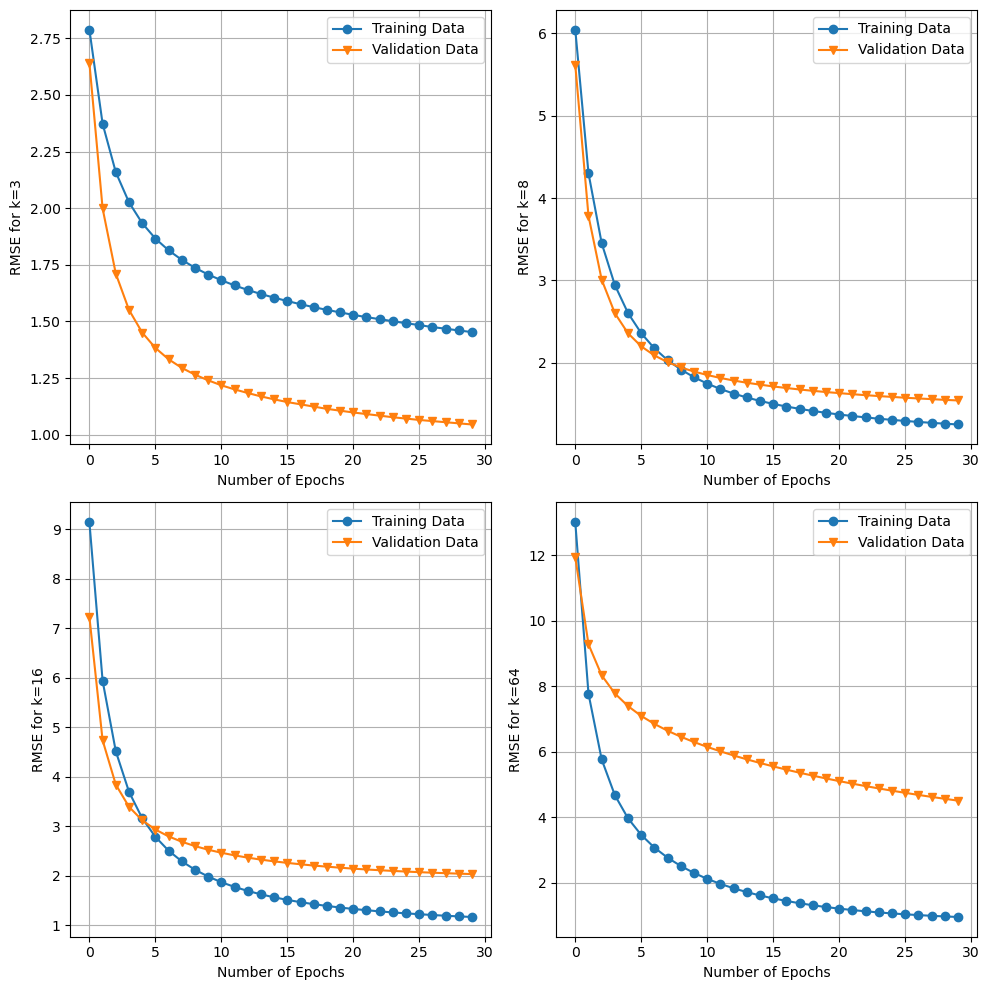

In [39]:
kvalues = values_df.k.unique()
newdf = {elem : pd.DataFrame() for elem in kvalues}

for key in newdf.keys():
    newdf[key] = values_df[:][values_df.k == key]

plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams["figure.autolayout"] = True

plt.subplot(221)
plt.plot(range(n_epochs), 'train_errors', data=newdf[3], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[3], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=3');
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(range(n_epochs), 'train_errors', data=newdf[8], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[8], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=8');
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(range(n_epochs), 'train_errors', data=newdf[16], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[16], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=16');
plt.legend()
plt.grid()

plt.subplot(224)
plt.plot(range(n_epochs), 'train_errors', data=newdf[64], marker='o', label='Training Data');
plt.plot(range(n_epochs), 'val_errors', data=newdf[64], marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE for k=64');
plt.legend()
plt.grid()